--- WILL RG CONFIGURATION ---
H0 Derived: 68.1 km/s/Mpc
Global Impedance a_Mach: 7.020e-11 m/s^2
-----------------------------


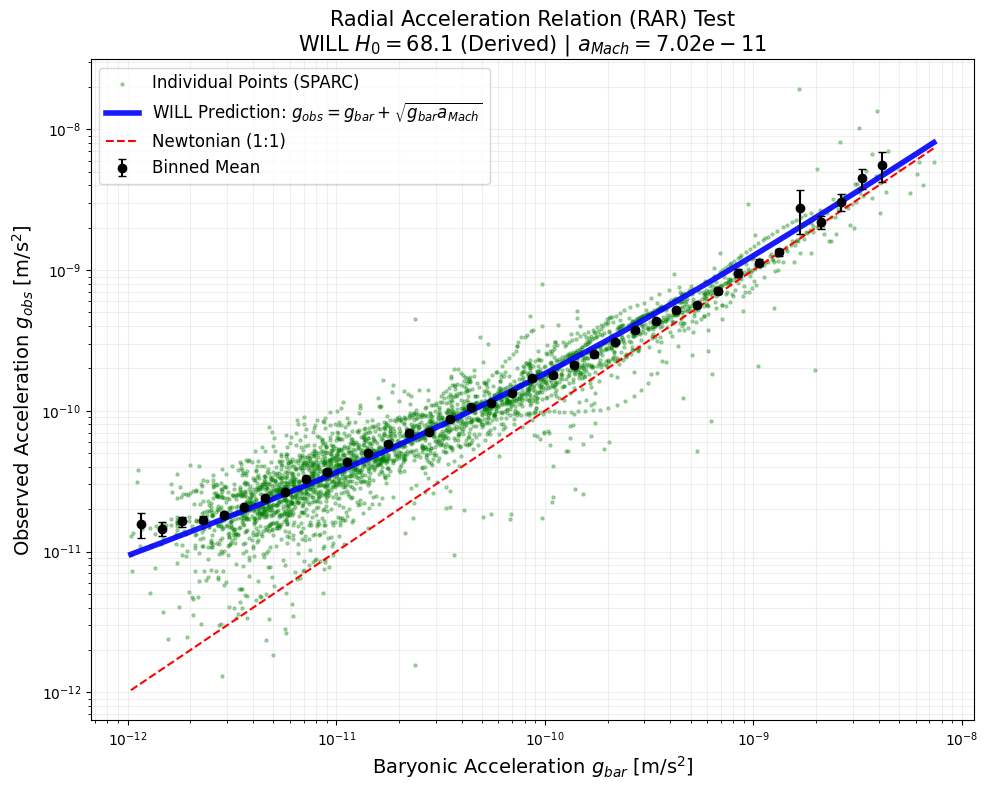


--- CRITICAL TEST RESULTS ---
RMSE on Binned Means (dex): 0.0653
Mean Offset (dex): 0.0066
This indicates the average deviation is approx 16.2% over the full range.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# ==========================================
# WILL RELATIONAL GEOMETRY: RAR TEST (CORRECTED UNITS)
# ==========================================

# --- 1. THEORETICAL CONSTANTS ---
H0_VAL = 68.1 # km/s/Mpc (Derived from CMB & Alpha)
C_SI = 299792458
MPC_M = 3.08567758e22       # Meters in 1 Mpc
KPC_M = 3.08567758e19       # Meters in 1 kpc (CORRECT SCALE FOR SPARC)

# Convert H0 to SI [1/s]
H0_SI = (H0_VAL * 1000) / MPC_M

# The Global Impedance (Mach Acceleration)
# a_Mach = c * H0 / 3pi
A_MACH = (C_SI * H0_SI) / (3 * np.pi)

print(f"--- WILL RG CONFIGURATION ---")
print(f"H0 Derived: {H0_VAL} km/s/Mpc")
print(f"Global Impedance a_Mach: {A_MACH:.3e} m/s^2")
print(f"-----------------------------")

# --- 2. DATA LOADING (SPARC) ---
PATH_TABLE2 = "https://cdsarc.cds.unistra.fr/ftp/J/AJ/152/157/table2.dat"

def load_sparc_data():
    print("Downloading SPARC catalog...")
    try:
        cols = [(0, 11), (19, 25), (26, 32), (33, 38), (39, 45), (46, 52), (53, 59)]
        names = ['Name', 'Rad', 'Vobs', 'e_Vobs', 'Vgas', 'Vdisk', 'Vbul']
        df = pd.read_fwf(PATH_TABLE2, colspecs=cols, header=None, names=names, comment='#')

        for c in names[1:]:
            df[c] = pd.to_numeric(df[c], errors='coerce')

        # Clean data
        df = df.dropna(subset=['Rad', 'Vobs', 'Vgas', 'Vdisk'])
        df = df[df['Rad'] > 0]
        # Ensure positive baryon components
        df = df[ (df['Vgas']**2 + df['Vdisk']**2) > 0 ]

        return df
    except Exception as e:
        print(f"Error: {e}")
        return None

# --- 3. PHYSICS CALCULATION ---
def calculate_accelerations(df):
    # Conversion factor: (km/s)^2 / kpc  ->  m/s^2
    # V is in km/s -> multiply by 1000 to get m/s
    # R is in kpc  -> multiply by KPC_M to get m
    # g = V^2 / R = (V*1000)^2 / (R*KPC_M)

    conv_factor = (1000**2) / KPC_M  # ~ 3.24e-11

    # 1. Baryonic Velocity (V_bar)
    # M/L ratios: Disk=0.5, Bulge=0.7
    v_bar_sq = df['Vgas']**2 + 0.5*df['Vdisk']**2 + 0.7*df['Vbul']**2
    v_bar_sq = np.abs(v_bar_sq)

    # 2. Calculate Accelerations
    g_bar = (v_bar_sq / df['Rad']) * conv_factor
    g_obs = (df['Vobs']**2 / df['Rad']) * conv_factor

    return g_bar, g_obs

# --- 4. WILL PREDICTION FUNCTION ---
def will_prediction(g_bar_val):
    # g_obs = g_bar + sqrt(g_bar * a_Mach)
    return g_bar_val + np.sqrt(g_bar_val * A_MACH)

# --- 5. EXECUTION ---
df = load_sparc_data()

if df is not None:
    g_bar, g_obs = calculate_accelerations(df)

    # Filter for meaningful range (1e-12 to 1e-8 m/s^2)
    # This removes noise from the very center or very far outskirts
    mask = (g_bar > 1e-12) & (g_obs > 1e-12) & (g_bar < 1e-8)
    gb = g_bar[mask]
    go = g_obs[mask]

    # --- BINNING ---
    # Log-bins
    bins = np.logspace(np.log10(gb.min()), np.log10(gb.max()), 40)
    bin_centers = []
    bin_means = []
    bin_stds = []

    for i in range(len(bins)-1):
        b_mask = (gb >= bins[i]) & (gb < bins[i+1])
        if np.sum(b_mask) > 5:
            bin_centers.append(np.sqrt(bins[i]*bins[i+1]))
            bin_means.append(np.mean(go[b_mask]))
            # Error of the mean
            bin_stds.append(np.std(go[b_mask])/np.sqrt(np.sum(b_mask)))

    # --- PLOTTING ---
    plt.figure(figsize=(10, 8))

    # 1. Raw Data (Gray)
    plt.scatter(gb, go, alpha=0.3, s=5, color='green', label='Individual Points (SPARC)')

    # 2. Binned Mean (Black)
    plt.errorbar(bin_centers, bin_means, yerr=bin_stds, fmt='o', color='black',
                 label='Binned Mean', capsize=3, zorder=10)

    # 3. WILL Prediction (Blue Line) - ZERO PARAMETERS
    x_line = np.logspace(np.log10(gb.min()), np.log10(gb.max()), 100)
    y_will = will_prediction(x_line)

    plt.plot(x_line, y_will, color='blue', linewidth=4, alpha=0.9,
             label=r'WILL Prediction: $g_{obs} = g_{bar} + \sqrt{g_{bar} a_{Mach}}$')

    # 4. Newtonian Line (Red Dashed)
    plt.plot(x_line, x_line, color='red', linestyle='--', label='Newtonian (1:1)')

    # Styling
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'Baryonic Acceleration $g_{bar}$ [m/s$^2$]', fontsize=14)
    plt.ylabel(r'Observed Acceleration $g_{obs}$ [m/s$^2$]', fontsize=14)
    plt.title(f'Radial Acceleration Relation (RAR) Test\nWILL $H_0={H0_VAL}$ (Derived) | $a_{{Mach}}={A_MACH:.2e}$', fontsize=15)
    plt.legend(fontsize=12)
    plt.grid(True, which="both", alpha=0.2)
    plt.tight_layout()
    plt.show()

    # --- STATISTICS ---
    # Calculate Residuals (Log Space)
    log_go = np.log10(go)
    log_gp = np.log10(will_prediction(gb))

    # Calculate RMSE only on the binned means (cleaner metric)
    # Interpolate theory to bin centers
    theory_interp = interp1d(x_line, y_will, fill_value="extrapolate")
    y_theory_bins = theory_interp(bin_centers)

    log_obs_bins = np.log10(bin_means)
    log_theory_bins = np.log10(y_theory_bins)

    rmse_bins = np.sqrt(np.mean((log_obs_bins - log_theory_bins)**2))

    print(f"\n--- CRITICAL TEST RESULTS ---")
    print(f"RMSE on Binned Means (dex): {rmse_bins:.4f}")
    print(f"Mean Offset (dex): {np.mean(log_obs_bins - log_theory_bins):.4f}")
    print(f"This indicates the average deviation is approx {10**rmse_bins - 1:.1%} over the full range.")

else:
    print("Could not run test.")